In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature

#import utils.contrastive_decoder_utils
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/c22c25c6-a' # 30000

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = True

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/c22c25c6-a/cfg_args
Config file found: ./output/c22c25c6-a/cfg_args
Loading trained model at iteration 30000, 10000
os.path.join(args.source_path, "sparse") /home/niranjanar/masterThesis/SegAnyGAussians_final/data/lund_50/sparse
Allow Camera Principle Point Shift: False
Reading camera 56/56
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    all_scales.append(cam.mask_scales)
all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

9.971948 ?


/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (833). n_quantiles is set to n_samples.
  warnings.warn(


In [5]:
all_scales.max()

tensor(9.9719, grad_fn=<MaxBackward1>)

In [6]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [7]:
upper_bound_scale

9.97194766998291

In [8]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Begin Segmenting

In [9]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 56 views in the dataset.
9.97194766998291


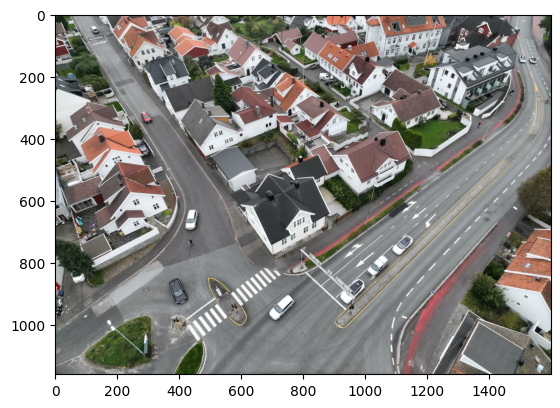

In [10]:
ref_img_camera_id = 17
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29477185..0.3293192].


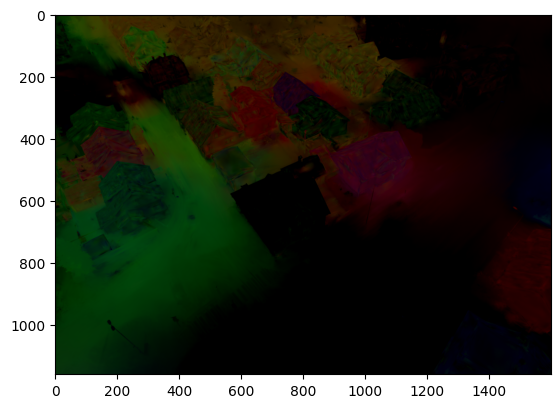

In [11]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.5]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy())

In [12]:
'''query_index = (800, 700)

query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)


plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)'''

"query_index = (800, 700)\n\nquery_index = (\n    int(query_index[0] / view.image_height * view.feature_height),\n    int(query_index[1] / view.image_width * view.feature_width),\n               )\n\nnormed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)\nquery_feature = normed_features[query_index[0], query_index[1]]\n\nsimilarity = torch.einsum('C,HWC->HW', query_feature, normed_features)\n\n\nplt.subplot(1,2,1)\nplt.imshow(similarity.detach().cpu().numpy())\nplt.subplot(1,2,2)\nplt.imshow(similarity.detach().cpu().numpy() > 0.75)"

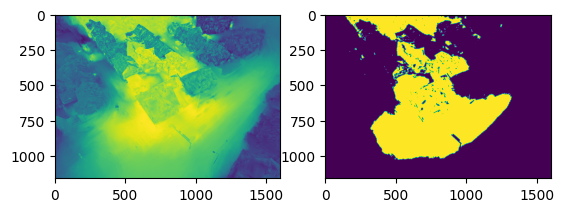

In [13]:
query_indices = [(450, 600),(400, 850) ,(650, 950),(300, 700),(720, 630),(800,700)]  # Manually pick more patches
normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
similarities = []
query_features = []
for qi in query_indices:
    qi_scaled = (
        int(qi[0] / view.image_height * view.feature_height),
        int(qi[1] / view.image_width * view.feature_width),
    )
    query_feature = normed_features[qi_scaled[0], qi_scaled[1]]
    query_features.append(query_feature)

    sim = torch.einsum('C,HWC->HW', query_feature, normed_features)
    similarities.append(sim)

# Combine multiple similarity maps
final_similarity = torch.stack(similarities).max(dim=0)[0]
plt.subplot(1,2,1)
plt.imshow(final_similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(final_similarity.detach().cpu().numpy() > 0.75)

In [14]:
'''import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1. Render the original image from view
img = view.original_image * 255
img = img.permute([1, 2, 0]).detach().cpu().numpy().astype(np.uint8)
img_resized = cv2.resize(img, (feature_w, feature_h))  # resize to match feature map

# 2. Compute similarity map (you already have this)
# similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)
sim_map = similarity.detach().cpu().numpy()
sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())  # normalize to 0-1

# 3. Convert similarity map to heatmap
heatmap = cv2.applyColorMap((sim_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
# Make sure heatmap and image have same resolution
if img_resized.shape[:2] != heatmap.shape[:2]:
    heatmap = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))

# Make sure both are 3-channel
if len(img_resized.shape) == 2:
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

# Now blend
overlay = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

# 4. Blend heatmap with image
#overlay = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

# 5. Show the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_resized)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("CLIP Similarity Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")
plt.tight_layout()
plt.show()'''

'import matplotlib.pyplot as plt\nimport cv2\nimport numpy as np\n\n# 1. Render the original image from view\nimg = view.original_image * 255\nimg = img.permute([1, 2, 0]).detach().cpu().numpy().astype(np.uint8)\nimg_resized = cv2.resize(img, (feature_w, feature_h))  # resize to match feature map\n\n# 2. Compute similarity map (you already have this)\n# similarity = torch.einsum(\'C,HWC->HW\', query_feature, normed_features)\nsim_map = similarity.detach().cpu().numpy()\nsim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())  # normalize to 0-1\n\n# 3. Convert similarity map to heatmap\nheatmap = cv2.applyColorMap((sim_map * 255).astype(np.uint8), cv2.COLORMAP_JET)\nheatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)\n# Make sure heatmap and image have same resolution\nif img_resized.shape[:2] != heatmap.shape[:2]:\n    heatmap = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))\n\n# Make sure both are 3-channel\nif len(img_resized.shape) == 2:\n    img_res

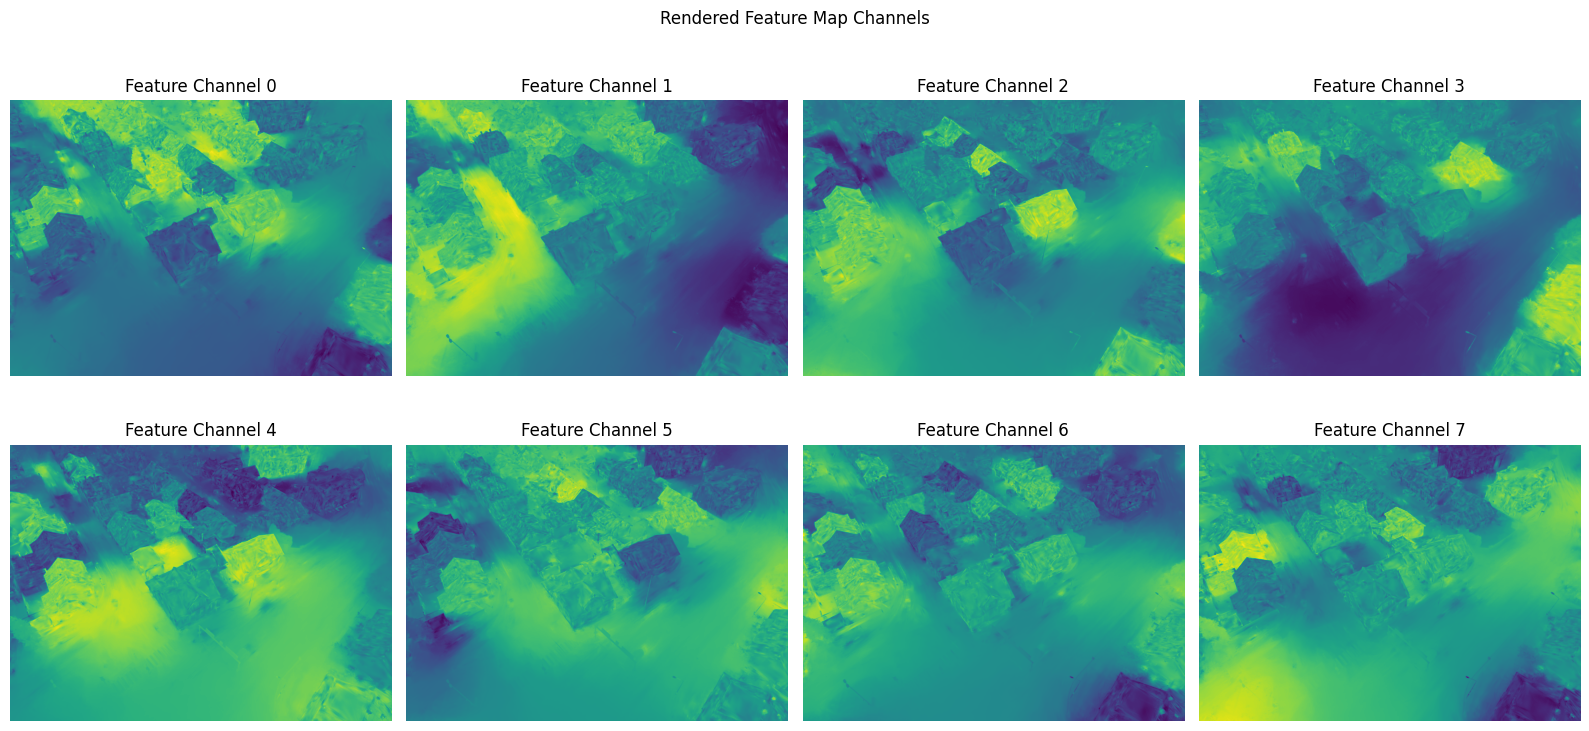

In [15]:
feature_map = rendered_feature.detach().cpu()  # (C, H, W)
C, H, W = feature_map.shape

# Show first 8 channels (you can change this)
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(feature_map[i], cmap='viridis')
    plt.title(f"Feature Channel {i}")
    plt.axis('off')
plt.suptitle("Rendered Feature Map Channels")
plt.tight_layout()
plt.show()


In [16]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)


# # t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
# t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

# t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
# t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
# plt.imshow(t)

# Cluster in 2D

In [17]:
#!pip install hdbscan

In [18]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

In [19]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105]


In [20]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

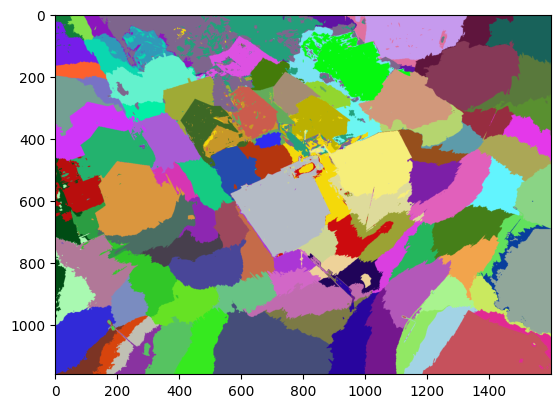

In [21]:
plt.imshow(colored_labels)

# Segmentation in 3D

After obtaining query features, we can use it to segment objects in 3D.

In [22]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = point_features * gates.unsqueeze(0)


In [23]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)
print(normed_scale_conditioned_point_features.device, query_feature.device, similarities.device)

similarities[similarities < 0.3] = 0

cuda:0 cuda:0 cuda:0


In [24]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
#rendered_similarities = render(cameras[0], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']
rendered_similarities = render(
    cameras[5], scene_gaussians, pipeline.extract(args), background
)['render']

Type: <class 'torch.Tensor'>
Device: cuda:0
Shape: torch.Size([3, 1159, 1600])
Min: tensor(0.0026, device='cuda:0', grad_fn=<MinBackward1>)
Max: tensor(1.0570, device='cuda:0', grad_fn=<MaxBackward1>)
Has NaN? tensor(False, device='cuda:0')
Has Inf? tensor(False, device='cuda:0')


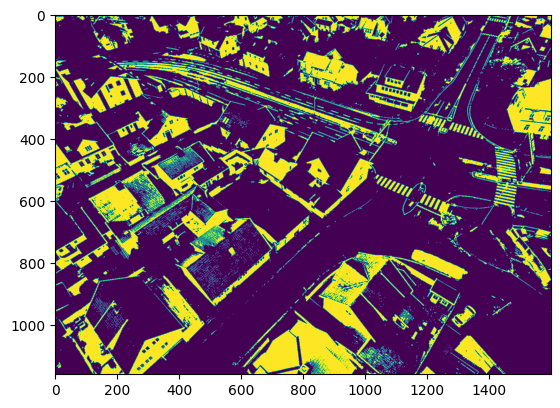

In [25]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print("Type:", type(rendered_similarities))
print("Device:", rendered_similarities.device)
print("Shape:", rendered_similarities.shape)
print("Min:", rendered_similarities.min())
print("Max:", rendered_similarities.max())
print("Has NaN?", torch.isnan(rendered_similarities).any())
print("Has Inf?", torch.isinf(rendered_similarities).any())

plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.6)

In [26]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.3)

In [27]:
# save the segmentation
name = 'precomputed_mask_multiquery'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.3, f'./segmentation_res/{name}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00020832765..1.7913783].


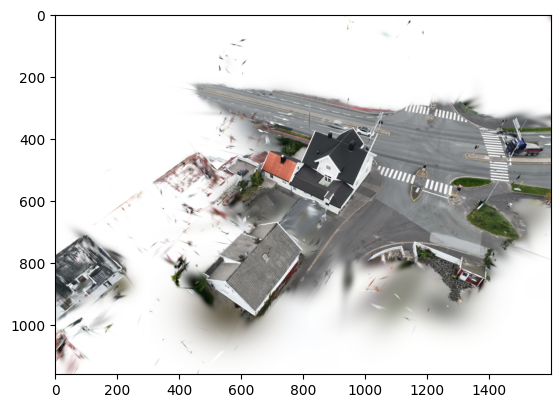

In [28]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[3], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

In [29]:
scene_gaussians.roll_back()

# Cluster in 3D

In [30]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

50002


In [31]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 24

In [32]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [33]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [34]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [35]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[0], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

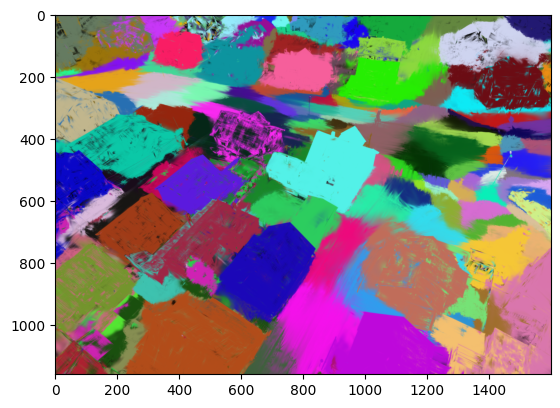

In [36]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

# Language-driven Segmentation

In [37]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))

25185


In [38]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # N_scale N_anchor C
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        scales.append(view.mask_scales.cuda().unsqueeze(-1))

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()

In [39]:
flattened_mask_features = torch.cat(seg_features, dim = 0)
flattened_clip_features = torch.cat(clip_features, dim = 0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

(torch.Size([833, 32]),
 torch.Size([833, 512]),
 torch.Size([833, 1]),
 torch.Size([833, 25185]),
 833)

In [40]:

with torch.no_grad():
    distance_map = 1 - (torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) / (flattened_mask_identifiers.sum(dim = -1).unsqueeze(-1) + flattened_mask_identifiers.sum(dim = -1).unsqueeze(0) - torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) + 1e-6))

In [41]:
# Construct vote graph

from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)

In [42]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip
clip_model = load_clip()
clip_model.eval()
1

Embedding dimension 512


1

In [43]:
# Convert input text prompts to scores for multi-view masks

'''scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "house")
scores = scores.squeeze()'''

'scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "house")\nscores = scores.squeeze()'

In [44]:
prompts = ["house", "building", "villa", "cabin", "roof","home","apartment","houses"]
all_scores = []

for prompt in prompts:
    scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), prompt)
    print(' prompt', prompt)
    print('score',scores)
    all_scores.append(scores.squeeze())  # (N,) for each class


 prompt house
score tensor([[0.6559],
        [0.6487],
        [0.6649],
        [0.6082],
        [0.4838],
        [0.7461],
        [0.7122],
        [0.6720],
        [0.6720],
        [0.6072],
        [0.7029],
        [0.6519],
        [0.6266],
        [0.6311],
        [0.6157],
        [0.6592],
        [0.6817],
        [0.6711],
        [0.5887],
        [0.6377],
        [0.5129],
        [0.7404],
        [0.7153],
        [0.6666],
        [0.6594],
        [0.6960],
        [0.6198],
        [0.6526],
        [0.5846],
        [0.7159],
        [0.5486],
        [0.6015],
        [0.6289],
        [0.6412],
        [0.6928],
        [0.6989],
        [0.6871],
        [0.4924],
        [0.6112],
        [0.6387],
        [0.6728],
        [0.6907],
        [0.7279],
        [0.6839],
        [0.5846],
        [0.6850],
        [0.5963],
        [0.6559],
        [0.6545],
        [0.5470],
        [0.5798],
        [0.6476],
        [0.6120],
        [0.6633],
        

In [45]:
cluster_scores = torch.zeros(len(torch.unique(cluster_labels)), device=cluster_labels.device)
for cluster_idx in torch.unique(cluster_labels):
    cluster_scores[cluster_idx] = scores[cluster_labels == cluster_idx].mean()

In [46]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_idx, scores):
    max_score_mask_scale_id = scores[cluster_labels == cluster_idx].argmax()
    return flattened_scales[cluster_labels == cluster_idx][max_score_mask_scale_id].item(), max_score_mask_scale_id

cluster_labels.unique(), cluster_labels.unique()[cluster_scores.argmax()], cluster_scores.max()

(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 tensor(6),
 tensor(0.6626))

In [47]:
good_clusters = torch.where(cluster_scores > 0.45)[0]
good_cluster_scores = cluster_scores[good_clusters]
print('cluster_scores',cluster_scores)
print('good cluster_scores',good_cluster_scores)
if len(good_clusters) != 0:
    print(len(good_clusters))
    good_clusters = [cluster_labels.unique()[i] for i in good_clusters]
else:
    good_clusters = [cluster_labels.unique()[cluster_scores.argmax()]]

clip_query_features = []
corresponding_scales = []

for g in good_clusters:

    s, ind = cluster_id_to_scales(cluster_labels, flattened_scales, g, scores)
    clip_query_features.append(torch.nn.functional.normalize(flattened_mask_features[cluster_labels == g][ind], dim = -1, p = 2))

    corresponding_scales.append(s)

cluster_scores tensor([0.6488, 0.6076, 0.6443, 0.5874, 0.5690, 0.6442, 0.4645, 0.6626, 0.6457,
        0.6502, 0.5767, 0.5912])
good cluster_scores tensor([0.6488, 0.6076, 0.6443, 0.5874, 0.5690, 0.6442, 0.4645, 0.6626, 0.6457,
        0.6502, 0.5767, 0.5912])
12


In [48]:
from typing import Callable
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:Callable, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    # scale = 0.5
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)

    gates = scale_gate(scale).detach().squeeze()

    print(point_features.shape, gates.shape)

    scale_conditioned_point_features = point_features * gates.unsqueeze(0)

    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


In [49]:
index = 0
similarities = get_similarity_map(feature_gaussians.get_point_features, corresponding_scales[index], scale_gate, clip_query_features[index], q_trans)
good_cluster_scores

torch.Size([2500265, 32]) torch.Size([32])


tensor([0.6488, 0.6076, 0.6443, 0.5874, 0.5690, 0.6442, 0.4645, 0.6626, 0.6457,
        0.6502, 0.5767, 0.5912])

In [50]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.45)

name = 'language_50'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.15, f'./segmentation_res/{name}.pt')

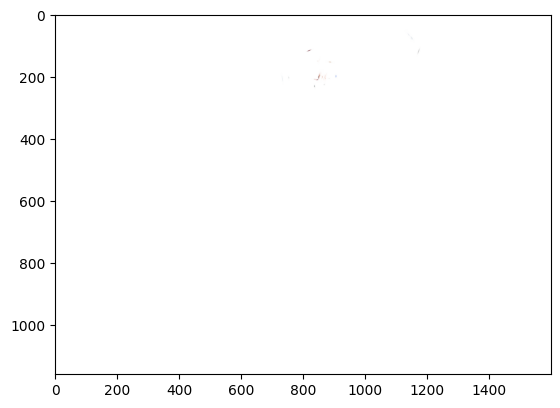

In [51]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[3], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
